This notebook contains the code relating to section 4.4.2 of the thesis: 64-by-64-pixel patch-wise segmentation

## Installations

In [ ]:
pip -q install wandb

     |████████████████████████████████| 1.6 MB 5.6 MB/s 
     |████████████████████████████████| 133 kB 51.1 MB/s 
     |████████████████████████████████| 170 kB 28.2 MB/s 
     |████████████████████████████████| 97 kB 3.1 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 


In [ ]:
pip -q install tensorflow_addons

     |████████████████████████████████| 679 kB 5.1 MB/s 


In [ ]:
import numpy as np
import nibabel
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from __future__ import print_function

from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io

import keras
from keras.models import Model, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization, Flatten, Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import layers

import wandb
from wandb.keras import WandbCallback

from tqdm.auto import tqdm

os.getcwd()

'/content'

In [ ]:
def get_tpu_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu="grpc://" + os.environ["COLAB_TPU_ADDR"]
        )  # TPU detection
        print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    except ValueError:
        raise BaseException("ERROR: Not connected to a TPU runtime")

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    return tf.distribute.TPUStrategy(tpu)

In [ ]:
tpu_strategy = get_tpu_strategy()

In [ ]:
# give permission to read data from google cloud bucket
from google.colab import auth
auth.authenticate_user()

## Load training and validation data in TFRecords format 

In [ ]:
def _parse_image_function(example_proto):

    """
    Reads from TFRecord file
    Returns a tf.train.Example object (can be read like a dictionary)
    """

    image_feature_description = {

        "image_raw": tf.io.FixedLenFeature([64 * 64], tf.float32),
        "mask_raw": tf.io.FixedLenFeature([64 * 64], tf.int64),
        #"mask_binary_raw": tf.io.FixedLenFeature([], tf.int64),
    }

    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _unpack_proto_aug(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [64, 64, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [64, 64, 1])

    # DATA AUGMENTATION
    if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_left_right(image)
      mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
      image = tf.image.rot90(image)
      mask = tf.image.rot90(mask)

    return image, mask

def _unpack_proto(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [64, 64, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [64, 64, 1])

    #mask_binary = example_proto["mask_binary_raw"]
    # mask_binary = tf.reshape(mask_binary, [1])

    return image, mask#, mask_binary

In [ ]:
def optimise_dataset(ds):

  """
  Improve performance of tensorflow dataset
  """

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  # ds = ds.cache()
  return ds

def prepare_data(ds, shuffle=True):
  """
  Normalise, batch, shuffle and optimise the dataset
  """
  # ds = normalise(ds)
  if shuffle:
    ds = ds.shuffle(5000)
  batch_size = 8 * tpu_strategy.num_replicas_in_sync # 16*8 (tpu_strategy.num_replicas_in_sync value shown in output of previous cell)
  ds = ds.batch(batch_size)
  ds = optimise_dataset(ds)
  return ds

def to_3_channels(image, mask):
  img_shape = (64,64)
  image = tf.reshape(tf.repeat(image, 3), (*img_shape, 3))
  # mask = tf.reshape(tf.repeat(mask, 3), (*img_shape, 3)) 
  return image, mask

## Load training & validation data

In [ ]:
train_empty_gcs_pattern = "gs://tf_records_patches_64by64/tfrecordstrain_empty*"
train_empty_filenames = tf.io.gfile.glob(train_empty_gcs_pattern)

train_nonempty_gcs_pattern = "gs://tf_records_patches_64by64/tfrecordstrain_non_empty*"
train_nonempty_filenames = tf.io.gfile.glob(train_nonempty_gcs_pattern)

train_empty_ds = tf.data.TFRecordDataset(train_empty_filenames)
train_empty_ds = train_empty_ds.map(_parse_image_function)
train_empty_ds = train_empty_ds.map(_unpack_proto)
train_empty_ds = train_empty_ds.map(to_3_channels)

train_nonempty_ds = tf.data.TFRecordDataset(train_nonempty_filenames)
train_nonempty_ds = train_nonempty_ds.map(_parse_image_function)
train_nonempty_ds = train_nonempty_ds.map(_unpack_proto)
train_nonempty_ds = train_nonempty_ds.map(to_3_channels)

train_datasets = [train_nonempty_ds.repeat(), train_empty_ds.repeat()]
train_ds = tf.data.experimental.sample_from_datasets(train_datasets, [0.5,0.5])

train_ds = prepare_data(train_nonempty_ds)

In [ ]:
val_empty_gcs_pattern = "gs://tf_records_patches_64by64/tfrecordsval_empty*"
val_empty_filenames = tf.io.gfile.glob(val_empty_gcs_pattern)

val_nonempty_gcs_pattern = "gs://tf_records_patches_64by64/tfrecordsval_non_empty*"
val_nonempty_filenames = tf.io.gfile.glob(val_nonempty_gcs_pattern)

val_empty_ds = tf.data.TFRecordDataset(val_empty_filenames)
val_empty_ds = val_empty_ds.map(_parse_image_function)
val_empty_ds = val_empty_ds.map(_unpack_proto)
val_empty_ds = val_empty_ds.map(to_3_channels)

val_nonempty_ds = tf.data.TFRecordDataset(val_nonempty_filenames)
val_nonempty_ds = val_nonempty_ds.map(_parse_image_function)
val_nonempty_ds = val_nonempty_ds.map(_unpack_proto)
val_nonempty_ds = val_nonempty_ds.map(to_3_channels)

val_datasets = [val_nonempty_ds.repeat(), val_empty_ds.repeat()]
val_ds = tf.data.experimental.sample_from_datasets(val_datasets, [0.5,0.5])

val_ds = prepare_data(val_nonempty_ds)

## Display Images

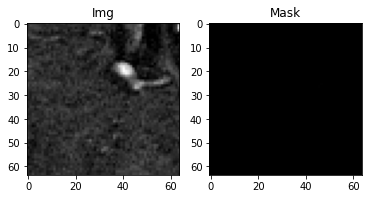

In [ ]:
def display_img_mask(batch_num, img_num):

  for images, labels in train_ds.take(batch_num):  # only take first element of dataset
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      # numpy_binary = binary.numpy()

  # print(numpy_binary.shape)

  plt.subplot(1,2,1)
  plt.imshow(numpy_images[img_num])
  plt.title('Img')

  plt.subplot(1,2,2)
  plt.imshow(numpy_labels[img_num])
  plt.title('Mask')

  # print(numpy_binary[img_num])

display_img_mask(4,25)

In [ ]:
# train_ds and valid_ds are unpacked into images and masks for viewing purposes

train_images = list(train_ds.take(1))
train_masks = np.concatenate([img[1] for img in train_images])
train_images = np.concatenate([img[0] for img in train_images])

val_images = list(val_ds.take(1))
val_masks = np.concatenate([img[1] for img in val_images])
val_images = np.concatenate([img[0] for img in val_images])

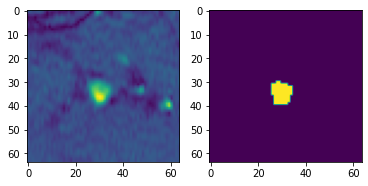

In [ ]:
img_num = 60

plt.subplot(1,2,1)
plt.imshow(train_images[img_num].reshape((64,64)))

plt.subplot(1,2,2)
plt.imshow(train_masks[img_num].reshape((64,64)))

## Loss Function

In [ ]:
# return our metric and loss

with tpu_strategy.scope():

  def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2* intersection + smooth)/(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



  def dice_coef_loss(y_true, y_pred):

    return -dice_coef(y_true, y_pred)


  def mixed_loss(y_true, y_pred):

    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)

    bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f, from_logits=False)
    dice = dice_coef(y_true, y_pred)

    return bce #+ (1 - dice) 

## Model Architecture

In [ ]:
# model parameters

with tpu_strategy.scope():

  lr = 1e-6
  # loss = dice_coef_loss
  # loss = tf.keras.losses.binary_crossentropy
  loss = mixed_loss
  metrics = dice_coef
  # metrics = ['binary_accuracy']

### Original Model

In [ ]:
with tpu_strategy.scope():

  inputs = Input((64, 64, 1))
  conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1) # 64 x 64 x 16
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 32 x 32 x 16

  conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) 
  conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2) # 32 x 32 x 32
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 16 x 16 x 32

  conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) # 16 x 16 x 64
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) # 8 x 8 x 64

  conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) # 8 x 8 x 128
  pool4 = MaxPooling2D(pool_size=(2,2))(conv4) # 4 x 4 x 128

  conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5) # 4 x 4 x 256

  up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3) # upsample conv5 (8 x 8 x 128) + conv4 (8 x 8 x 128) = 8 x 8 x 256
  conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
  conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6) # 8 x 8 x 128

  up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3) # upsample conv6 (16 x 16 x 64) + conv3 (16 x 16 x 64) = 16 x 16 x 128
  conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
  conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7) # 16 x 16 x 64

  up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3) # upsample conv7 (32 x 32 x 32) + conv2 (32 x 32 x 32) = 32 x 32 x 64
  conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
  conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8) # 32 x 32 x 32

  up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3) # upsample conv8 (64 x 64 x 16) + conv1 (64 x 64 x 16) = 64 x 64 x 32
  conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
  conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9) # 64 x 64 x 16

  conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) # 64 x 64 x 1

  model = Model(inputs=[inputs], outputs=[conv10])
  model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)

### Original Model (with dropout)

In [ ]:
with tpu_strategy.scope():

  inputs = Input((128, 128, 1))
  conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1) # 128 x 128 x 16
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 64 x 64 x 16
  drop1 = Dropout(0.2)(pool1)

  conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(drop1) 
  conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2) # 64 x 64 x 32
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 32 x 32 x 32
  drop2 = Dropout(0.2)(pool2)

  conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop2)
  conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) # 32 x 32 x 64
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) # 16 x 16 x 64
  drop3 = Dropout(0.2)(pool3)

  conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop3)
  conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) # 16 x 16 x 128
  pool4 = MaxPooling2D(pool_size=(2,2))(conv4) # 8 x 8 x 128
  drop4 = Dropout(0.2)(pool4)

  conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop4)
  conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5) # 8 x 8 x 256

  up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3) # upsample conv5 (16 x 16 x 128) + conv4 (16 x 16 x 128) = 16 x 16 x 256
  conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
  conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6) # 16 x 16 x 128

  up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3) # upsample conv6 (32 x 32 x 64) + conv3 (32 x 32 x 64) = 32 x 32 x 128
  conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
  conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7) # 32 x 32 x 64

  up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3) # upsample conv7 (64 x 64 x 32) + conv2 (64 x 64 x 32) = 64 x 64 x 64
  conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
  conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8) # 64 x 64 x 32

  up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3) # upsample conv8 (128 x 128 x 16) + conv1 (128 x 128 x 16) = 128 x 128 x 32
  conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
  conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9) # 128 x 128 x 16

  conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) # 128 x 128 x 1

  model = Model(inputs=[inputs], outputs=[conv10])
  model.compile(optimizer=Adam(), loss=loss, metrics=metrics)

### Pre-trained Model: Original

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
def rescale_output(y_pred):

  y_pred = tf.clip_by_value(y_pred, clip_value_min=0., clip_value_max=1.) # force values to be between 0 and 1

  return y_pred

In [ ]:
zeros = tf.zeros([2, 64, 64, 1])
tf.reshape(tf.repeat(zeros, 3), (2, 64, 64, 3))

In [ ]:
# with tpu_strategy.scope(): 

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[64, 64, 3])
  resize_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (96, 96)))
  x = resize_layer(inputs)

  # Downsampling through the model
  base_model = tf.keras.applications.MobileNetV2(input_shape=[96, 96, 3], include_top=False) # ImageNet weights only work with 3 channel images

  # x = base_model(x)
  # Use the activations of these layers
  layer_names = [
      'block_1_expand_relu',   # 48x48
      'block_3_expand_relu',   # 24x24
      'block_6_expand_relu',   # 12x12
      'block_13_expand_relu',  # 6x6
      'block_16_project',      # 3x3
  ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

  # # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

  down_stack.trainable = False

  up_stack = [
      pix2pix.upsample(576, 3),  # 4x4 -> 8x8
      pix2pix.upsample(192, 3),  # 8x8 -> 16x16
      pix2pix.upsample(144, 3),  # 16x16 -> 32x32
      pix2pix.upsample(96, 3),   # 32x32 -> 64x64
  ]


  skips = down_stack(x)
  x = skips[-1] # final output of encoder
  skips = reversed(skips[:-1]) # all outputs of encoder except final, reversed
  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x) # pass output of encoder through decoder (iterates through outputs of decoder)
    concat = tf.keras.layers.Concatenate() 
    x = concat([x, skip]) # cross-link: output of decoder concatenated with encoder output
  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  # # normalise_output = tf.keras.layers.Lambda(rescale_output)

  x = last(x)
  shrinking_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (64, 64)))
  x = shrinking_layer(x)
  x = tf.keras.activations.sigmoid(x)
  # x = normalise_output(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(output_channels=1)

model.compile(optimizer=AdamW(weight_decay=1e-6, learning_rate=3e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=dice_coef)
# model.summary()
model.predict(tf.expand_dims(img[0], axis=[0])).shape

(1, 64, 64, 1)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# tf.keras.utils.plot_model(base_model, show_shapes=True)
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
________________

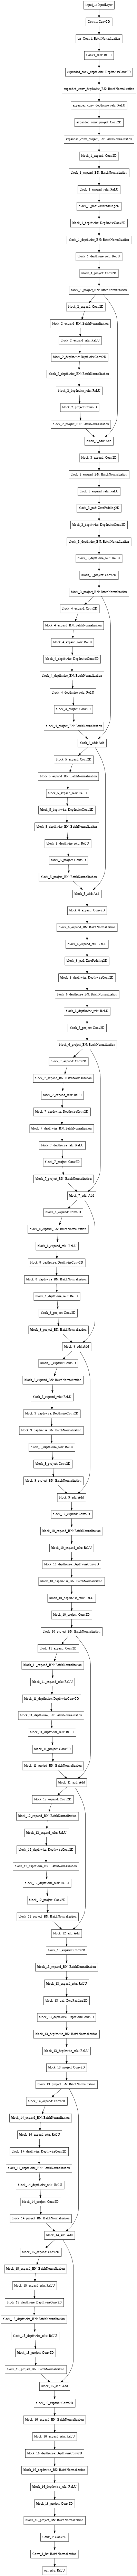

In [ ]:
tf.keras.utils.plot_model(base_model, dpi=48)

## Training the model

### Learning rate scheduler & early stopping

In [ ]:
def build_learning_rate_cycler(
    lr_start=1e-5,
    lr_max=5e-5,
    lr_min=1e-6,
    lr_rampup_epochs=10,
    lr_sustain_epochs=2,
    lr_exp_decay=0.9,
):
    lr_max = lr_max

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (
                epoch - lr_rampup_epochs - lr_sustain_epochs
            ) + lr_min
        return lr

    return lrfn

lr_cycler = build_learning_rate_cycler(
          lr_start=1e-6,
          lr_max=3e-4,
          lr_min=1e-7,
          lr_rampup_epochs=20,
          lr_sustain_epochs=0,
          lr_exp_decay=0.9,
      )


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=10,
                    restore_best_weights=True,
                    mode='auto')

### Find the optimal learning rate

In [ ]:
model = unet_model(output_channels=1)
          
model.compile(optimizer=AdamW(weight_decay=1e-6, learning_rate=1e-4),
                        loss=dice_coef_loss,
                        metrics=dice_coef)

initial_weights = model.get_weights()
len(initial_weights), initial_weights

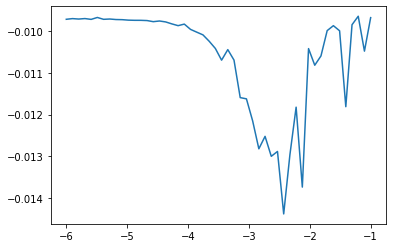

In [ ]:
def find_learning_rate(num_rates=50):
    rates = np.logspace(-6, -1, num=num_rates)
    img, label = list(train_ds.take(1))[0]
    losses = []
    for rate in tqdm(rates):
          model = unet_model(output_channels=1)

          model.compile(optimizer=AdamW(weight_decay=1e-6, learning_rate=rate),
                        loss=dice_coef_loss,
                        metrics=dice_coef)
          model.set_weights(initial_weights)
          model.fit(img, label, epochs=5, verbose=0)
          losses.append(model.history.history['loss'][0])
    return losses, rates
# losses, rates = find_learning_rate(50)
plt.plot(np.log10(rates), losses)

### Training the pre-trained model

In [ ]:
with tpu_strategy.scope():

  model = unet_model(output_channels=1)

  model.compile(optimizer=AdamW(weight_decay=1e-6, learning_rate=1e-3),
                loss=dice_coef_loss,
                metrics=dice_coef)

  EPOCHS = 250

  history = model.fit(
      train_ds.take(5), 
      epochs=30,
      validation_data=val_ds) # single batch

  # history = model.fit(train_ds.take(12).shuffle(5000), epochs=EPOCHS,
  #                           validation_data=val_ds.take(4), callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1), WandbCallback(), early_stopping])

Epoch 1/30
5/5 [==============================] - 18s 1s/step - loss: -0.0157 - dice_coef: 0.0157 - val_loss: -0.0091 - val_dice_coef: 0.0091
Epoch 2/30
5/5 [==============================] - 1s 271ms/step - loss: -0.0218 - dice_coef: 0.0218 - val_loss: -0.0138 - val_dice_coef: 0.0138
Epoch 3/30
5/5 [==============================] - 1s 294ms/step - loss: -0.0500 - dice_coef: 0.0500 - val_loss: -0.0326 - val_dice_coef: 0.0326
Epoch 4/30
5/5 [==============================] - 2s 448ms/step - loss: -0.1330 - dice_coef: 0.1330 - val_loss: -0.0507 - val_dice_coef: 0.0507
Epoch 5/30
5/5 [==============================] - 1s 271ms/step - loss: -0.2989 - dice_coef: 0.2989 - val_loss: -0.0469 - val_dice_coef: 0.0469
Epoch 6/30
5/5 [==============================] - 1s 298ms/step - loss: -0.4971 - dice_coef: 0.4971 - val_loss: -0.0224 - val_dice_coef: 0.0224
Epoch 7/30
5/5 [==============================] - 1s 257ms/step - loss: -0.6387 - dice_coef: 0.6387 - val_loss: -0.0226 - val_dice_coef: 0

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18]),
 <a list of 10 Text major ticklabel objects>)

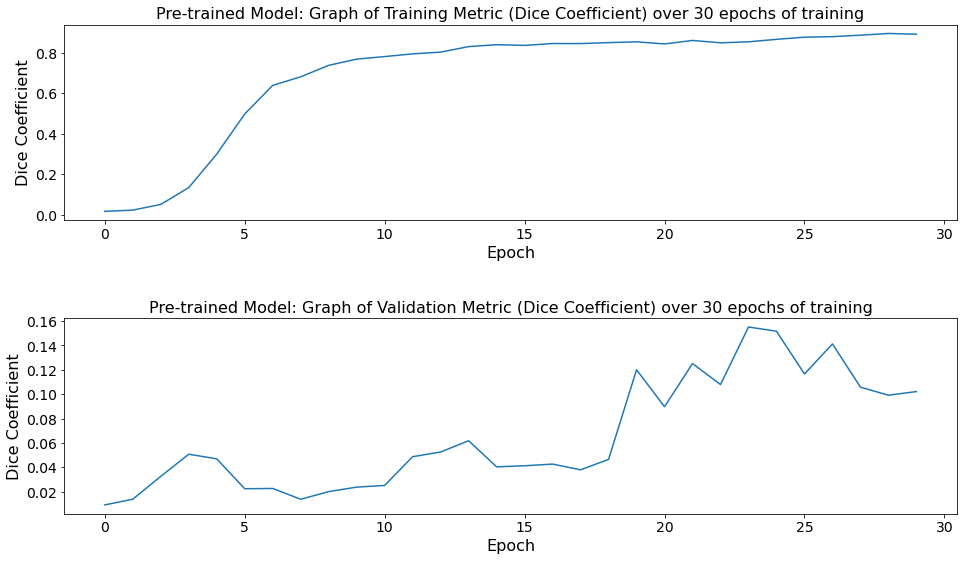

In [ ]:
plt.figure(figsize=(16, 9)) 

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

plt.subplot(2,1,1)
plt.plot(history.history['dice_coef'])
plt.title('Pre-trained Model: Graph of Training Metric (Dice Coefficient) over 30 epochs of training', size=16)
plt.xlabel('Epoch', size=16)
plt.ylabel('Dice Coefficient', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(2,1,2)
plt.plot(history.history['val_dice_coef'])
plt.title('Pre-trained Model: Graph of Validation Metric (Dice Coefficient) over 30 epochs of training', size=16)
plt.xlabel('Epoch', size=16)
plt.ylabel('Dice Coefficient', size=16)
plt.xticks(size=14)
plt.yticks(size=14)


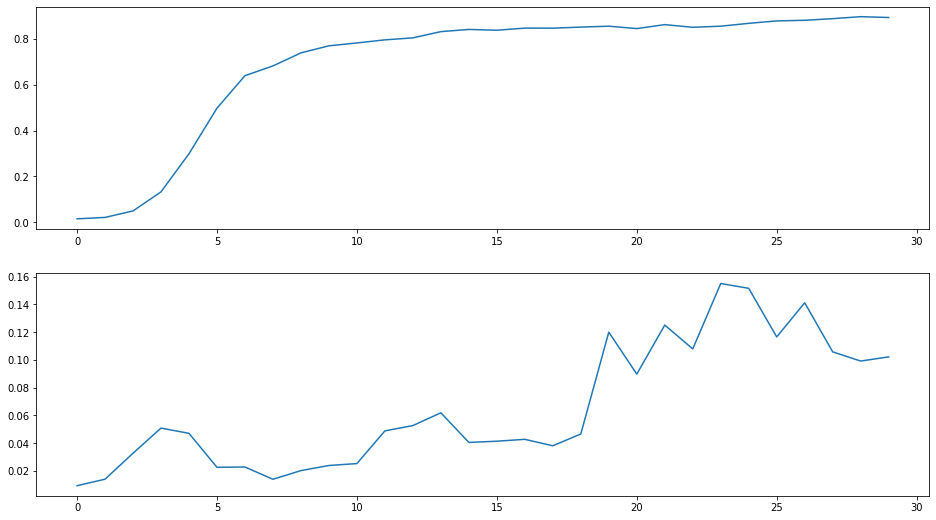

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 9))
axes[0].plot(history.history['dice_coef'])
axes[1].plot(history.history['val_dice_coef'])


## Test Set

In [ ]:
print('Loading and preprocessing test data (non-empty masks)...')

test_non_empty_gcs_pattern = "gs://tf_records_patches_64by64/tfrecordstest_non_empty*"
test_non_empty_filenames = tf.io.gfile.glob(test_non_empty_gcs_pattern)
test_non_empty_ds = tf.data.TFRecordDataset(test_non_empty_filenames)

test_non_empty_ds = test_non_empty_ds.map(_parse_image_function)
test_non_empty_ds = test_non_empty_ds.map(_unpack_proto)

test_ds = prepare_data(test_non_empty_ds)

Loading and preprocessing test data (non-empty masks)...


In [ ]:
test_pairs = list(test_ds.take(1))

test_images = [pair[0] for pair in test_pairs]
test_images_to_display = np.concatenate(test_images)

test_masks_orig = [pair[1] for pair in test_pairs]
test_masks_orig = np.concatenate(test_masks_orig)

In [ ]:
def compare_img_mask(img_num):

  """
  Display original image with mask, true mask and predicted mask for a specified image number
  
  Args:
  train_, test_ or valid_ + images/masks/preds
  """
  
  plt.figure(figsize=(20, 4)) 

  plt.subplot(1,3,1)
  plt.imshow(test_images_to_display[img_num].reshape((64,64)))
  plt.title('Original image patch')

  plt.subplot(1,3,2)
  plt.imshow(test_masks_orig[img_num].reshape((64,64)))
  plt.title('True mask')

  plt.subplot(1,3,3)
  plt.imshow(test_preds[img_num].reshape((64,64)))
  plt.title('Predicted mask')

In [ ]:
print('Predicting masks on test data...')

test_preds = [model.predict(batch) for batch in test_images]
test_preds = np.concatenate(test_preds)

Predicting masks on test data...


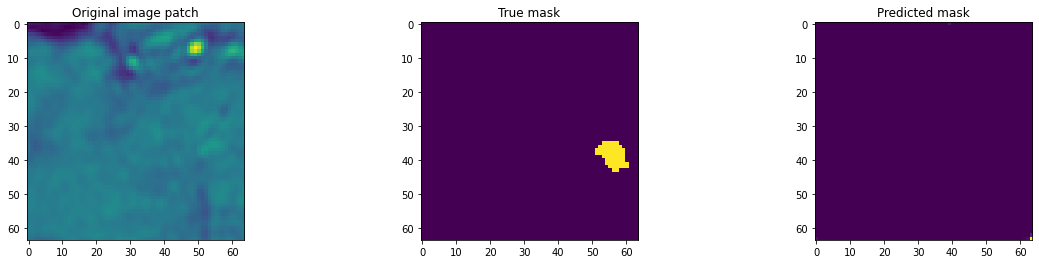

In [ ]:
compare_img_mask(10)

In [ ]:
# calculate dice coeff for each pair of true (test_masks) and predicted (test_preds) masks in the test set

dice_coeff_list = []
dice_coeff_dict = {}

for i in range(len(test_masks_orig)):
  true_mask = test_masks_orig[i]
  pred_mask = test_preds[i].reshape((64,64))
  pred_mask = np.round(pred_mask)

  dice_coeff = np.array(dice_coef(true_mask, pred_mask))
  dice_coeff_list.append(dice_coeff)
  dice_coeff_dict[i] = dice_coeff

np.mean(dice_coeff_list), np.std(dice_coeff_list)

(0.11583396, 0.1217709)

Text(0, 0.5, 'Number of Images')

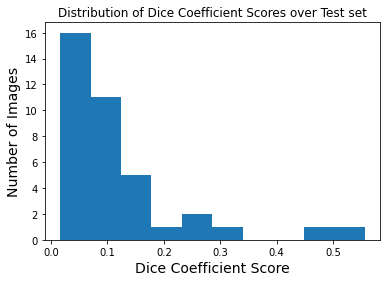

In [ ]:
plt.hist(dice_coeff_list)
plt.title('Distribution of Dice Coefficient Scores over Test set')
plt.xlabel('Dice Coefficient Score', size=14)
plt.ylabel('Number of Images', size=14)

In [ ]:
# create lists 'low' and 'high' that store indices of low and high scoring masks respectively

low = []
med = []
high = []

for key,val in dice_coeff_dict.items():
  if val<0.1:
    low.append(key)
  elif val<0.5 and val>0.3:
    med.append(key)
  elif val>0.5:
    high.append(key)


len(low), len(med), len(high)

(23, 1, 1)

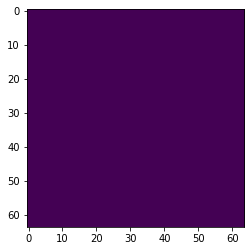

In [ ]:
plt.imshow(np.where(test_preds[7]>0.5,1,0).reshape((64,64)))

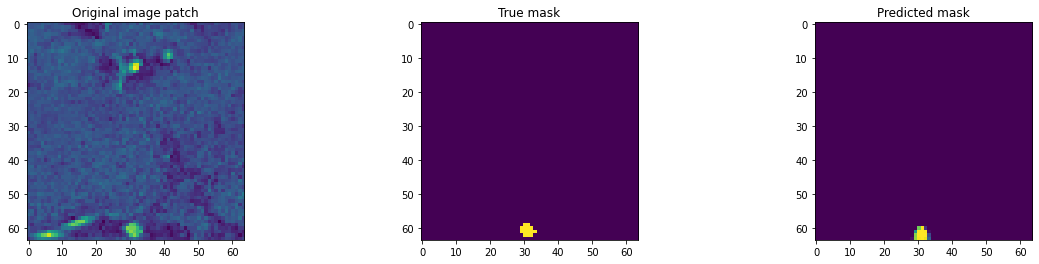

In [ ]:
compare_img_mask(5)

## Predict

In [ ]:
def min_max_scale(img):
    img = tf.squeeze(img)
    max_val = tf.reduce_max(img)
    min_val = tf.reduce_min(img)
    return (img - min_val)/(max_val-min_val)

In [ ]:
preds = model.predict(val_images)
preds.shape

(64, 64, 64, 1)

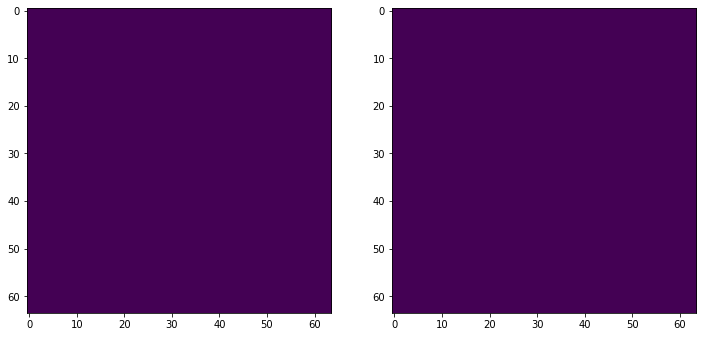

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,12))
index = 22
# axes[0].imshow(tf.squeeze(min_max_scale(preds[index])))
axes[0].imshow(tf.squeeze(preds[index]))
axes[1].imshow(tf.squeeze(val_masks[index]))

## Other Metrics

In [ ]:
# Hausdorff Distance

from scipy.spatial.distance import directed_hausdorff

img_num = 32

u = test_images_to_display[img_num].reshape((64,64))
v = test_preds[img_num].reshape((64,64))

# v = np.where(v>0.5,1,0)

directed_hausdorff(u,v)[0]

2.5608472089575742

In [ ]:
labelPred=sitk.GetImageFromArray(v, isVector=False)
labelTrue=sitk.GetImageFromArray(u, isVector=False)

hausdorffcomputer = sitk.HausdorffDistanceImageFilter()

# hausdorffcomputer.Execute(labelPred>0.5,labelTrue>0.5)
hausdorffcomputer.Execute(labelPred,labelTrue)

hausdorffcomputer.GetAverageHausdorffDistance()

7.573977428884182

In [ ]:
dicecomputer=sitk.LabelOverlapMeasuresImageFilter()
dicecomputer.Execute(labelTrue>0.5,labelPred>0.5)
dicecomputer.GetDiceCoefficient()

0.18666666666666665